In [310]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from scipy.stats import binom

from matplotlib import pyplot as plt

## Brief description of the dataset and a summary of its attributes
We import the dataset and explore its characteristics. The dataset contains one numerical variable and 8 objects, that are either strings or dates. The measurements are monthly measurements and the date column, holds the respective dates.

In [214]:
df = pd.read_csv('data.csv')

In [215]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50799 entries, 0 to 50798
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      50799 non-null  int64  
 1   date            50799 non-null  object 
 2   datatype        50799 non-null  object 
 3   station         50799 non-null  object 
 4   attributes      50778 non-null  object 
 5   value           50799 non-null  float64
 6   countryid       50799 non-null  object 
 7   id              50799 non-null  object 
 8   datacategoryid  50799 non-null  object 
 9   name            50799 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.9+ MB
None


The dataset includes 10 different features on temperature and precipitation.

In [216]:
print(df[['datacategoryid', 'id', 'name']].drop_duplicates(ignore_index=True))

   datacategoryid    id                                               name
0            TEMP  CDSD                 Cooling Degree Days Season to Date
1            TEMP  EMNT        Extreme minimum temperature for the period.
2            TEMP  EMXT        Extreme maximum temperature for the period.
3            TEMP  HDSD                 Heating Degree Days Season to Date
4            TEMP  TAVG                               Average Temperature.
5            TEMP  TMAX                                Maximum temperature
6            TEMP  TMIN                                Minimum temperature
7            PRCP  DSND  Number days with snow depth > 1 inch(25.4mm) f...
8            PRCP  EMSD         Extreme maximum snow depth for the period.
9            PRCP  EMXP      Extreme maximum precipitation for the period.
10           PRCP  PRCP                                      Precipitation


In [217]:
print(min(df['date']))
print(max(df['date']))

2014-01-01T00:00:00
2023-06-01T00:00:00


The measurements cover the period of Jan. 2014 - June 2023.

## Initial plan for data exploration
We cast each feature to a numerical variable and we check the basic statistics of those variables.

In [218]:
df.pivot(index = ['date', 'station'], columns = 'id', values = 'value')

id                                      CDSD  DSND  EMNT  EMSD  EMXP  EMXT  \
date                station                                                  
2014-01-01T00:00:00 GHCND:FG000081405    NaN   NaN   NaN   NaN  85.1   NaN   
                    GHCND:FGM00081401    NaN   NaN  19.7   NaN  35.1   NaN   
                    GHCND:FGM00081415    NaN   NaN  20.1   NaN  25.9   NaN   
                    GHCND:FP000091925    NaN   NaN   NaN   NaN  30.0  32.7   
                    GHCND:FP000091948    NaN   NaN   NaN   NaN  29.0   NaN   
...                                      ...   ...   ...   ...   ...   ...   
2023-06-01T00:00:00 GHCND:GRM00016622    NaN   NaN   NaN   NaN  37.3   NaN   
                    GHCND:GRM00016719  185.5   NaN  13.0   NaN   0.5  33.8   
                    GHCND:GRM00016726    NaN   NaN   NaN   NaN   1.8  33.4   
                    GHCND:MFM00067005    NaN   NaN   NaN   NaN   0.3   NaN   
                    GHCND:SBM00071805    NaN   NaN   NaN   NaN  17.8   NaN   

id                                      HDSD   PRCP   TAVG   TMAX   TMIN  
date                station                                               
2014-01-01T00:00:00 GHCND:FG000081405    NaN  594.7    NaN    NaN    NaN  
                    GHCND:FGM00081401    NaN  233.7    NaN    NaN  22.02  
                    GHCND:FGM00081415    NaN  161.8    NaN    NaN  22.32  
                    GHCND:FP000091925    NaN   81.4    NaN  30.73    NaN  
                    GHCND:FP000091948    NaN  126.4    NaN    NaN    NaN  
...                                      ...    ...    ...    ...    ...  
2023-06-01T00:00:00 GHCND:GRM00016622    NaN   94.3    NaN    NaN    NaN  
                    GHCND:GRM00016719  938.2    0.5  23.59  29.34  17.83  
                    GHCND:GRM00016726    NaN    3.9    NaN  29.57    NaN  
                    GHCND:MFM00067005    NaN    2.4    NaN    NaN    NaN  
                    GHCND:SBM00071805    NaN   76.8    NaN    NaN    NaN  

[9777 rows x 11 columns]

In [219]:
df_summary = df.groupby(['countryid', 'name', 'id'])['value'].agg([np.mean, np.median, np.std, min, max, lambda x : np.quantile(x, 0.25), 
                                                                   lambda x : np.quantile(x, 0.75), lambda x: x.count()])\
    .rename(columns = {"<lambda_0>":"25 percentile", "<lambda_1>":"75 percentile", "<lambda_2>":"Count"})

print(df_summary)

                                                                         mean  \
countryid name                                               id                 
FIPS:FR   Average Temperature.                               TAVG   13.641054   
          Cooling Degree Days Season to Date                 CDSD  147.630388   
          Extreme maximum precipitation for the period.      EMXP   20.382597   
          Extreme maximum snow depth for the period.         EMSD  214.636364   
          Extreme maximum temperature for the period.        EMXT   24.945502   
          Extreme minimum temperature for the period.        EMNT    3.745144   
          Heating Degree Days Season to Date                 HDSD  962.318617   
          Maximum temperature                                TMAX   18.299411   
          Minimum temperature                                TMIN    9.418633   
          Number days with snow depth > 1 inch(25.4mm) fo... DSND   20.454545   
          Precipitation     

## Data cleaning and feature engineering
we explore the dataset in its initial form, looking for outliers. We also simplify by removing the stations feature. Finally we explore the distribution of variables and look for the need of transformations or scaling. We do not need to deal with categorical variables. We only have numerical variables.

We get the interquartile range, and look for outliers.

In [220]:
df_summary['iqr'] = df_summary['75 percentile'] - df_summary['25 percentile']

In [221]:
df_summary['upper_limit'] = df_summary['75 percentile'] + 1.5 * df_summary['iqr']
df_summary['lower_limit'] = df_summary['25 percentile'] - 1.5 * df_summary['iqr']

In [222]:
display(df_summary[['upper_limit', 'lower_limit']])

upper_limit  \
countryid name                                               id                  
FIPS:FR   Average Temperature.                               TAVG     32.69875   
          Cooling Degree Days Season to Date                 CDSD    605.00000   
          Extreme maximum precipitation for the period.      EMXP     46.15000   
          Extreme maximum snow depth for the period.         EMSD    410.00000   
          Extreme maximum temperature for the period.        EMXT     50.05000   
          Extreme minimum temperature for the period.        EMNT     22.70000   
          Heating Degree Days Season to Date                 HDSD   4182.25000   
          Maximum temperature                                TMAX     40.42125   
          Minimum temperature                                TMIN     26.87000   
          Number days with snow depth > 1 inch(25.4mm) fo... DSND     43.00000   
          Precipitation                                      PRCP    171.60000   
FIPS:GR   Average Temperature.                               TAVG     40.87250   
          Cooling Degree Days Season to Date                 CDSD   1743.75000   
          Extreme maximum precipitation for the period.      EMXP     62.35000   
          Extreme maximum temperature for the period.        EMXT     53.68750   
          Extreme minimum temperature for the period.        EMNT     31.85000   
          Heating Degree Days Season to Date                 HDSD    155.06250   
          Maximum temperature                                TMAX     47.21875   
          Minimum temperature                                TMIN     35.03000   
          Precipitation                                      PRCP    155.75000   

                                                                   lower_limit  
countryid name                                               id                 
FIPS:FR   Average Temperature.                               TAVG     -5.35125  
          Cooling Degree Days Season to Date                 CDSD   -363.00000  
          Extreme maximum precipitation for the period.      EMXP    -11.85000  
          Extreme maximum snow depth for the period.         EMSD     -6.00000  
          Extreme maximum temperature for the period.        EMXT      0.05000  
          Extreme minimum temperature for the period.        EMNT    -15.70000  
          Heating Degree Days Season to Date                 HDSD  -2384.55000  
          Maximum temperature                                TMAX     -3.70875  
          Minimum temperature                                TMIN     -8.37000  
          Number days with snow depth > 1 inch(25.4mm) fo... DSND     -1.00000  
          Precipitation                                      PRCP    -54.80000  
FIPS:GR   Average Temperature.                               TAVG      0.17250  
          Cooling Degree Days Season to Date                 CDSD  -1046.25000  
          Extreme maximum precipitation for the period.      EMXP    -30.05000  
          Extreme maximum temperature for the period.        EMXT      2.78750  
          Extreme minimum temperature for the period.        EMNT     -8.15000  
          Heating Degree Days Season to Date                 HDSD    -93.03750  
          Maximum temperature                                TMAX      0.26875  
          Minimum temperature                                TMIN     -2.85000  
          Precipitation                                      PRCP    -82.05000

In [223]:
# Just some cleaning of the main table
df.reset_index()
df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [224]:
df = df.merge(df_summary[['upper_limit', 'lower_limit']], on = ['countryid', 'id'], how = "left")

In [225]:
# Check for outliers
outliers = df[(df['value']>df['upper_limit'])|(df['value']<df['lower_limit'])]

In [226]:
outliers.shape

(1296, 11)

We find that approx. 1000 rows in 50000 rows of dataset are extreme values, which is around 2%. Since there are several extreme values, we are going to keep them.

In [227]:
df.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            50789, 50790, 50791, 50792, 50793, 50794, 50795, 50796, 50797,
            50798],
           dtype='int64', length=50799)

In [228]:
display(df)

,date,datatype,station,attributes,value,countryid,id,datacategoryid,name,upper_limit,lower_limit
0,2014-01-01T00:00:00,CDSD,GHCND:FR000007130,E,0.0,FIPS:FR,CDSD,TEMP,Cooling Degree Days Season to Date,605.00,-363.00
1,2014-01-01T00:00:00,CDSD,GHCND:FR000007190,E,0.0,FIPS:FR,CDSD,TEMP,Cooling Degree Days Season to Date,605.00,-363.00
2,2014-01-01T00:00:00,CDSD,GHCND:FR000007255,E,0.0,FIPS:FR,CDSD,TEMP,Cooling Degree Days Season to Date,605.00,-363.00
3,2014-01-01T00:00:00,CDSD,GHCND:FR000007510,E,0.0,FIPS:FR,CDSD,TEMP,Cooling Degree Days Season to Date,605.00,-363.00
4,2014-01-01T00:00:00,CDSD,GHCND:FR000007630,E,0.0,FIPS:FR,CDSD,TEMP,Cooling Degree Days Season to Date,605.00,-363.00
...,...,...,...,...,...,...,...,...,...,...,...
50794,2023-06-01T00:00:00,PRCP,GHCND:GR000016754,",,,S",43.2,FIPS:GR,PRCP,PRCP,Precipitation,155.75,-82.05
50795,2023-06-01T00:00:00,PRCP,GHCND:GR000167230,"1,,,S",0.0,FIPS:GR,PRCP,PRCP,Precipitation,155.75,-82.05
50796,2023-06-01T00:00:00,PRCP,GHCND:GRM00016622,",,,S",94.3,FIPS:GR,PRCP,PRCP,Precipitation,155.75,-82.05
50797,2023-06-01T00:00:00,PRCP,GHCND:GRM00016719,",,,S",0.5,FIPS:GR,PRCP,PRCP,Precipitation,155.75,-82.05


For each day, we can have measurements taken at several stations. We can summarize those measurements and reduce the size of the dataset.

In [229]:
df_mean = df.groupby(['countryid', 'datacategoryid', 'datatype', 'name', 'date'])[['value']].agg(["mean", "median"])

In [230]:
display(df_mean)

value  \
                                                                                                               mean   
countryid datacategoryid datatype name                                               date                             
FIPS:FR   PRCP           DSND     Number days with snow depth > 1 inch(25.4mm) fo... 2014-02-01T00:00:00  28.000000   
                                                                                     2014-03-01T00:00:00  19.000000   
                                                                                     2015-01-01T00:00:00  12.000000   
                                                                                     2015-02-01T00:00:00  14.000000   
                                                                                     2015-03-01T00:00:00  19.000000   
...                                                                                                             ...   
FIPS:GR   TEMP           TMIN     Minimum temperature                                2023-02-01T00:00:00   5.080000   
                                                                                     2023-03-01T00:00:00   8.010000   
                                                                                     2023-04-01T00:00:00  10.546667   
                                                                                     2023-05-01T00:00:00  13.850000   
                                                                                     2023-06-01T00:00:00  19.026667   

                                                                                                                 
                                                                                                         median  
countryid datacategoryid datatype name                                               date                        
FIPS:FR   PRCP           DSND     Number days with snow depth > 1 inch(25.4mm) fo... 2014-02-01T00:00:00  28.00  
                                                                                     2014-03-01T00:00:00  19.00  
                                                                                     2015-01-01T00:00:00  12.00  
                                                                                     2015-02-01T00:00:00  14.00  
                                                                                     2015-03-01T00:00:00  19.00  
...                                                                                                         ...  
FIPS:GR   TEMP           TMIN     Minimum temperature                                2023-02-01T00:00:00   5.08  
                                                                                     2023-03-01T00:00:00   8.01  
                                                                                     2023-04-01T00:00:00   9.98  
                                                                                     2023-05-01T00:00:00  13.85  
                                                                                     2023-06-01T00:00:00  18.40  

[1804 rows x 2 columns]

In [231]:
df_mean.columns = ['_'.join(col) for col in df_mean.columns.values]

In [232]:
df_mean.columns.values

array(['value_mean', 'value_median'], dtype=object)

In [233]:
df_mean[['value_mean']].isna().sum() # No missing values here

value_mean    0
dtype: int64

In [234]:
df_mean_wide = df_mean.reset_index(['datatype', 'datacategoryid', 'name']).pivot(columns = 'datatype', values = 'value_mean')

In [243]:
df_mean_wide.isna().sum()

datatype
CDSD    105
DSND    217
EMNT     19
EMSD    217
EMXP      0
EMXT      6
HDSD     88
PRCP      0
TAVG     27
TMAX      6
TMIN     19
dtype: int64

After transforming to a wide form, we see that missing values appear in the e.g. temperature measurements, but not in the e.g. precipitation.

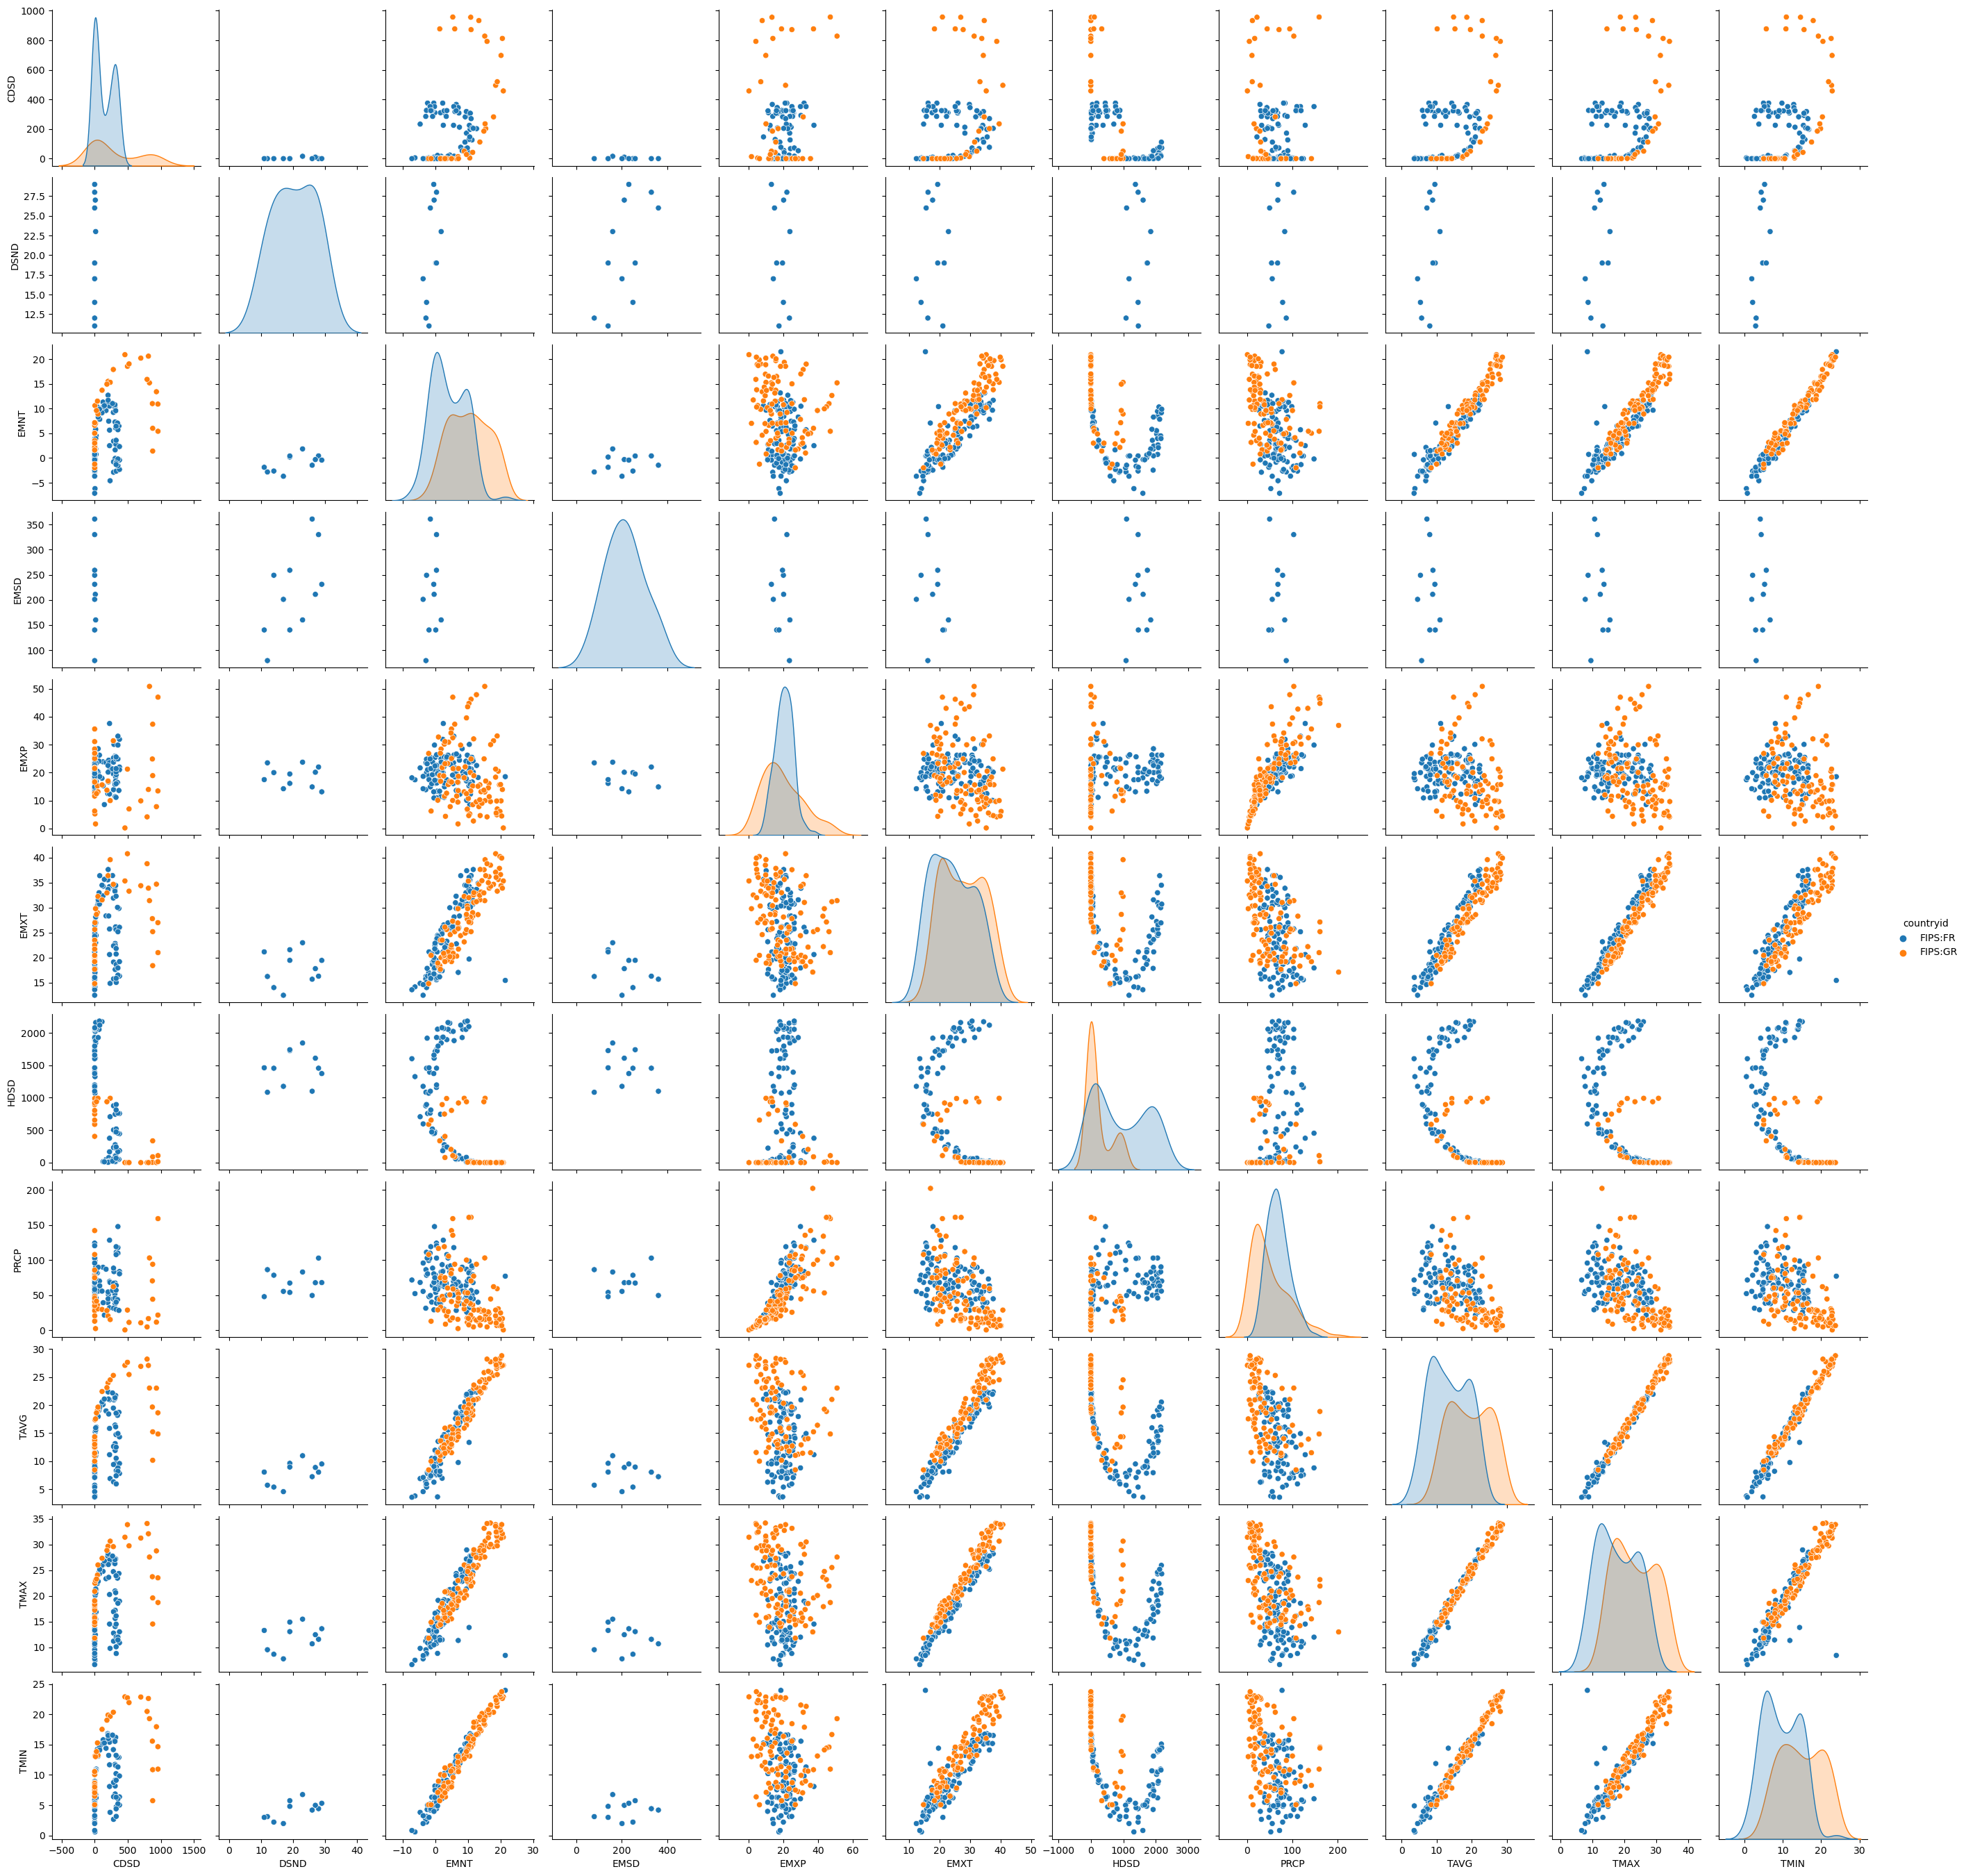

In [236]:
sns.pairplot(df_mean_wide.reset_index(), hue = 'countryid')

We check for skewed measurements in the combinations of datatype and countryid columns.

In [237]:
df_mean_skew = df_mean_wide.groupby('countryid').skew().reset_index().melt(id_vars = 'countryid')

In [238]:
df_mean_skew = df_mean_skew.set_index(['datatype', 'countryid'])
skew_cols = df_mean_skew[abs(df_mean_skew['value'])>0.75]

In [239]:
skew_cols

,,value
datatype,countryid,
CDSD,FIPS:GR,0.756271
HDSD,FIPS:GR,1.297929
PRCP,FIPS:GR,1.198044


For the variables that we transformed, compare before and after the transformation.

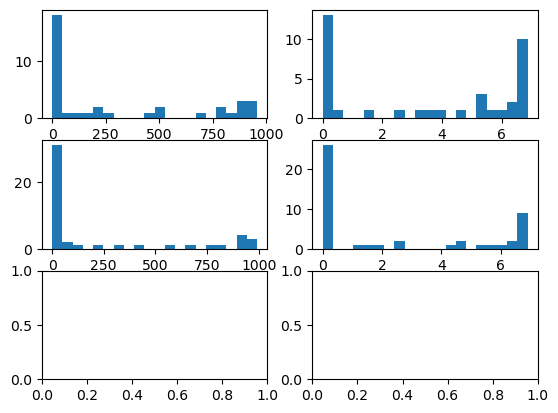

In [240]:
fig, ax = plt.subplots(3,2)
[ax[i,0].hist(df_mean_wide.loc[skew_cols.index.values[i][1], skew_cols.index.values[i][0]], bins = 20) for i in range(2)]
[ax[i,1].hist(df_mean_wide.loc[skew_cols.index.values[i][1], skew_cols.index.values[i][0]].apply(np.log1p), bins = 20) for i in range(2)]
plt.show()

In [241]:
# Apply the log transformation to the dataframe if we want
logTransform = False
if (logTransform == True) :
     for variable, country in skew_cols.index.values:
          df_mean_wide.loc[country, variable] = df_mean_wide.loc[country, variable].apply(np.log1p)


In [242]:
# Check that there is no skeweness in the transformed variables
df_mean_skew = df_mean_wide.groupby('countryid').skew().reset_index().melt(id_vars = 'countryid')
df_mean_skew = df_mean_skew.set_index(['datatype', 'countryid'])
skew_cols = df_mean_skew[abs(df_mean_skew['value'])>0.75]
[print(variable + country) for variable, country in skew_cols.index]

CDSDFIPS:GR
HDSDFIPS:GR
PRCPFIPS:GR


[None, None, None]

## Key findings and insights

Observations:

* Min, max and average temperatures, they follow linear relations one with each other.
* Temperatures follow a quadratic relation with heating/cooling degrees days. Cooling degrees days tends to increase with temperature, but there seems to be a threshold of days where it starts decreasing. It probably means that looking at large number of HDD, because it is cumulative it occurs at season with low temperatures. Similarly for heating degrees days, which is the demand of energy to heat a building, we see that HDD inrease as temperatures decrease, it reaches a minimum and then it is increasing also as temperatures increase. 
* looking at the relation between temperature and precipitation, it is not clear whether there is correlation between the two variables. Maybe further transformations can help to further understand the relation.

## Hypothesis testing

Hypothesis:

* There is no correlation between temperature and precipitation.
* Greece and France have similar behaviour on temperature. When the average temperature in Greece increases, also the same happens in France.
* Greece and France have similar behaviour on precipitation. When the precipitation in Greece increases, also the same happens in France.

### 1st hypothesis

* Null hypothesis: The correlation between temperature and precipitation is zero.
* Alternative hypothesis: The correlation between temperature and precipitation is different than zero.

To answer the question we need the true rate of the correlation coefficient. We take let's say 100 samples of measurements and calculate the probability that there is no correlation. We define as zero correlation when the correlation coefficient is in the interval [-0.1,0.1]

In [267]:
# Look for missing values in temperature and precipitation 
df_mean_wide[['PRCP', 'TAVG']].isna().sum()

datatype
PRCP     0
TAVG    27
dtype: int64

In [290]:
# Remove the missing values in temperature and precipitation
df_T_PRCP = df_mean_wide[(pd.isna(df_mean_wide['PRCP']) == False)&(pd.isna(df_mean_wide['TAVG']) == False)]
print(df_T_PRCP[['PRCP', 'TAVG']].isna().sum()) # check

datatype
PRCP    0
TAVG    0
dtype: int64


In [291]:
df_T_PRCP = df_T_PRCP[['PRCP', 'TAVG']]

# Take 1000 samples of 50 measurements and calculate the pearson correlation coefficient without replacement
dt_corrcoef = pd.DataFrame()

for i in range(1000):
    corrcoef_sample = scipy.stats.pearsonr(x = np.array(df_T_PRCP.sample(50, replace = True)).T[0], y = np.array(df_T_PRCP.sample(50, replace = True)).T[1]).correlation
    corrcoef_dt = pd.DataFrame([{'Sample':i, 'CorrCoef': corrcoef_sample}])
    dt_corrcoef = pd.concat([dt_corrcoef, corrcoef_dt], axis = 0)

In [292]:
#Calculate the probability of zero correlation in the samples
proba = dt_corrcoef[(dt_corrcoef['CorrCoef']<=0.1)&(dt_corrcoef['CorrCoef']>=-0.1)].shape[0]/1000
print(proba)

0.511


In [293]:
# We know the probability of getting zero correlation. And so we calculate the probability of getting the alternative hypothesis using the binomial distribution. 
prob1 = 1-binom.cdf(60, 100, (1-proba))
print("Out of 100 samples, the probability to have correlation in more than 60 of those is "+str(round(prob1*100, 1))+"%")

Out of 100 samples, the probability to have correlation in more than 60 of those is 1.0%


In [296]:
print("Out of 100 samples we have correlation in at least "+ str(binom.ppf(0.95,100,1-proba)+1)+" samples with confidence level 95%.")

Out of 100 samples we have correlation in at least 58.0 samples with confidence level 95%.


Therefore there is some form of correlation present and it is rather improbable that we have zero correlation.

### 2nd hypothesis

Greece and France have different temperatures.

* Null hypothesis: The temperatures in Greece and in France are the same.
* Alternative hyppothesis: The temperatures in Greece and in France are different.

We choose 5% significance level.

In [300]:
df_T = df_mean_wide[(pd.isna(df_mean_wide['TAVG']) == False)]
df_T = df_T[['countryid','TAVG']]
print(df_T)

datatype countryid       TAVG
0          FIPS:FR   7.576977
1          FIPS:FR   8.031957
2          FIPS:FR   9.610000
3          FIPS:FR  13.044894
4          FIPS:FR  14.306889
..             ...        ...
223        FIPS:GR   9.980000
224        FIPS:GR  12.990000
225        FIPS:GR  14.340000
226        FIPS:GR  18.610000
227        FIPS:GR  23.115000

[201 rows x 2 columns]


In [305]:
france=df_T.loc[df_T['countryid']=="FIPS:FR", 'TAVG']
greece=df_T.loc[df_T['countryid']=="FIPS:GR", 'TAVG']


C:\Users\tzava\AppData\Local\Temp\ipykernel_3252\2272142649.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(france,color='green',hist=False)
C:\Users\tzava\AppData\Local\Temp\ipykernel_3252\2272142649.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(greece,color='red',hi

<Axes: xlabel='TAVG', ylabel='Density'>

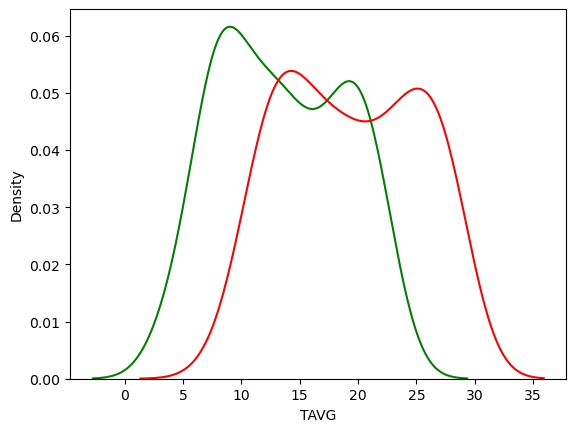

In [306]:
sns.distplot(france,color='green',hist=False)
sns.distplot(greece,color='red',hist=False)

From the density plots we observe that the distribution of the temperatures in Greece and in France are similar but there is a shift between them, showing that Greece has higher temperatures than France. Also we observe that in both countries the most common temperatures are towards the edges of the distribution rather than in the middle.

In [308]:
print(france.mean())
print(greece.mean())

13.501033918342605
19.411666666666665


We see that the mean temperature in Greece is higher than the mean temperature in France.

In [311]:
alpha=0.05
t_value1, p_value1 = stats.ttest_ind(france, greece)
print("t_value1 = ",t_value1, ", p_value1 = ", p_value1)

t_value1 =  -7.464618912987033 , p_value1 =  2.553322148087781e-12


In [313]:
if p_value1 <alpha:
    print("Conclusion: since p_value {} is less than alpha {} ". format (p_value1,alpha))
    print("Reject the null hypothesis that there is no difference between the temperatures in Greece and France.")
    
else:
    print("Conclusion: since p_value {} is greater than alpha {} ". format (p_value1,alpha))
    print("Fail to reject the null hypothesis that there is no difference between the temperatures in Greece and in France.")

Conclusion: since p_value 2.553322148087781e-12 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between the temperatures in Greece and France.


### 3rd hypothesis

Greece and France have different precipitation levels.

* Null hypothesis: The precipitation in Greece and in France is the same.
* Alternative hyppothesis: The precipitation in Greece and in France is different.

We choose 5% significance level.

In [314]:
df_PRCP = df_mean_wide[(pd.isna(df_mean_wide['PRCP']) == False)]
df_PRCP = df_PRCP[['countryid','PRCP']]
print(df_PRCP)

datatype countryid        PRCP
0          FIPS:FR  124.025301
1          FIPS:FR  102.704938
2          FIPS:FR   53.793750
3          FIPS:FR   49.677778
4          FIPS:FR   78.538272
..             ...         ...
223        FIPS:GR   12.775000
224        FIPS:GR   40.787500
225        FIPS:GR   45.712500
226        FIPS:GR   41.385714
227        FIPS:GR   27.900000

[228 rows x 2 columns]


In [316]:
france_PRCP=df_PRCP.loc[df_PRCP['countryid']=="FIPS:FR", 'PRCP']
greece_PRCP=df_PRCP.loc[df_PRCP['countryid']=="FIPS:GR", 'PRCP']


C:\Users\tzava\AppData\Local\Temp\ipykernel_3252\2817746939.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(france_PRCP,color='green',hist=False)
C:\Users\tzava\AppData\Local\Temp\ipykernel_3252\2817746939.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(greece_PRCP,colo

<Axes: xlabel='PRCP', ylabel='Density'>

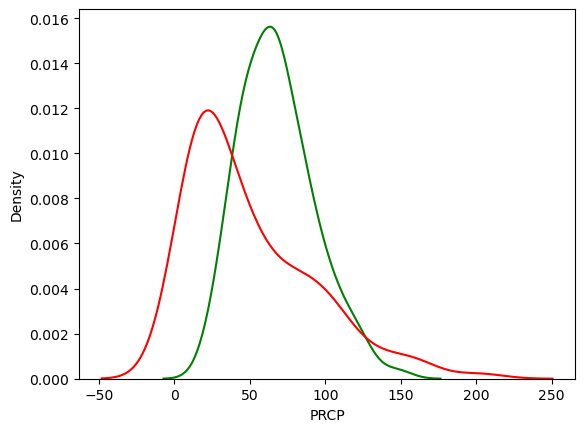

In [317]:
sns.distplot(france_PRCP,color='green',hist=False)
sns.distplot(greece_PRCP,color='red',hist=False)

In [318]:
print(france_PRCP.mean())
print(greece_PRCP.mean())

67.92803348086044
50.262224310776936


In [319]:
alpha=0.05
t_value1, p_value1 = stats.ttest_ind(france_PRCP, greece_PRCP)
print("t_value1 = ",t_value1, ", p_value1 = ", p_value1)

t_value1 =  3.886752810839097 , p_value1 =  0.0001335345719358334


In [320]:
if p_value1 <alpha:
    print("Conclusion: since p_value {} is less than alpha {} ". format (p_value1,alpha))
    print("Reject the null hypothesis that there is no difference between the precipitation in Greece and France.")
    
else:
    print("Conclusion: since p_value {} is greater than alpha {} ". format (p_value1,alpha))
    print("Fail to reject the null hypothesis that there is no difference between the precipitation in Greece and in France.")

Conclusion: since p_value 0.0001335345719358334 is less than alpha 0.05 
Reject the null hypothesis that there is no difference between the temperatures in Greece and France.
